In [1]:
from paretoCardinalityRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
def findApproximateParetoSolutionsRestaurants(simMatrix, item_ids, sample_size=None, num_runs=10, k_max=50, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Objective vs Cardinality).
    Parameters:
    - simMatrix: Similarity matrix
    - item_ids: List of item ids (restaurants)
    - sample_size: Optional subsample size for items
    - num_runs: Number of independent runs
    - k_max: Maximum cardinality
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["C-Greedy", "TopK", "Random"]

    # Subsample items if requested
    n_items = len(item_ids)
    if sample_size is None or sample_size <= 0 or sample_size >= n_items:
        selected_indices = np.arange(n_items)
    else:
        rng = np.random.default_rng()
        selected_indices = rng.choice(n_items, size=sample_size, replace=False)
    selected_indices = np.sort(selected_indices)
    sub_items = [item_ids[i] for i in selected_indices]
    sub_sim = simMatrix[np.ix_(selected_indices, selected_indices)]

    # containers across runs
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_objectives = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # C-Greedy (formerly ParetoGreedy-Cardinality)
        pareto = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto.paretoGreedy()
        objectives = [pareto.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['C-Greedy'] = objectives
        run_runtimes['C-Greedy'] = runTime

        # Top K
        pareto2 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto2.top_k()
        objectives = [pareto2.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['TopK'] = objectives
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto3.random_selection()
        objectives = [pareto3.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['Random'] = objectives
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_objectives[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (num_runs, k_max)
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0)

    # Plot mean objective with shaded std band (match cardinality teams formatting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "Random": tab10_colors[7],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "Random": "s",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (3, 2)),
        "Random": (0, (2, 2)),
    }
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        marker_size = 7
        line_style = linestyle_map.get(alg, (0, (1, 1)))
        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        ax.plot(range(1, k_max + 1), mean,
                label=rf"\texttt{{{alg}}}",
                color=color,
                linestyle=line_style,
                marker=marker,
                markersize=marker_size,
                markevery=3,
                markeredgewidth=1.1,
                markeredgecolor='k',
                linewidth=1.8,
                zorder=zorder)
        ax.fill_between(range(1, k_max + 1),
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)
    
    ax.set_xlabel(r'Cardinality, $k$', fontsize=28)
    ax.set_ylabel(r'Objective, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### Yelp Phoenix Experiments

In [3]:
#Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

2026-02-06 18:49:17,722 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=100
2026-02-06 18:49:20,800 |INFO: Cardinality Greedy Solution:[278, 274, 43, 227, 257, 31, 289, 206, 122, 113, 37, 71, 144, 261, 41, 200, 166, 238, 197, 97, 46, 16, 168, 10, 247, 120, 52, 107, 106, 176, 131, 209, 49, 61, 89, 145, 219, 18, 194, 282, 255, 280, 5, 110, 55, 124, 283, 102, 242, 220, 17, 140, 271, 237, 244, 15, 266, 279, 152, 281, 147, 171, 24, 260, 202, 19, 292, 88, 228, 26, 1, 103, 123, 164, 174, 161, 33, 7, 286, 51, 253, 63, 127, 109, 226, 181, 142, 265, 193, 259, 235, 148, 138, 207, 23, 100, 211, 277, 58, 275], Objective:155.168, Runtime = 3.08 seconds
2026-02-06 18:49:20,802 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=100
2026-02-06 18:49:21,954 |INFO: Top-k Solution:[278, 149, 189, 44, 122, 190, 177, 227, 8, 46, 273, 21, 91, 280, 245, 115, 71, 0, 160, 84, 3, 78, 141, 37, 79, 43, 222, 40, 274, 59, 38, 276,

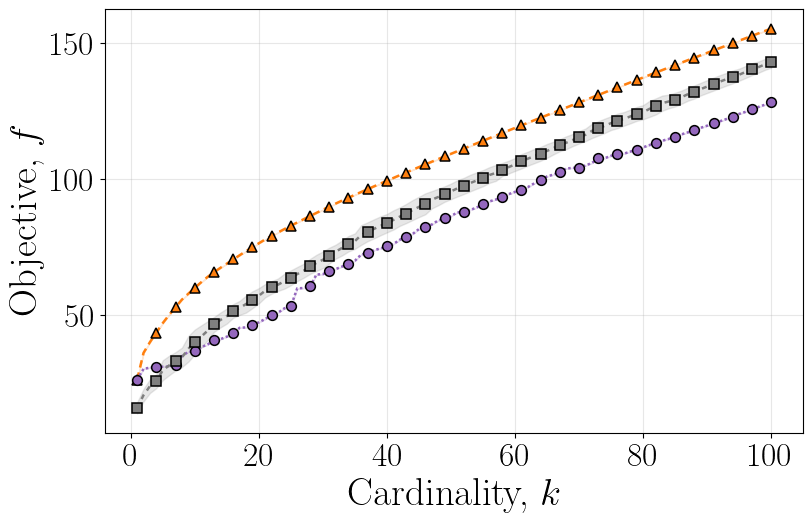

2026-02-06 18:49:42,627 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 3.005 ± 0.108
  - TopK: 1.211 ± 0.166
  - Random: 0.626 ± 0.092


In [4]:
# Adjust parameters as needed
sample_size = 300
num_runs = 5  # number of random runs
k_max = 100
findApproximateParetoSolutionsRestaurants(phoenix_simMatrix, phoenix_ids, sample_size, num_runs, k_max, "Yelp_Phoenix")

### Yelp Vegas Experiments

In [5]:
#Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

2026-02-06 18:49:42,670 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=100
2026-02-06 18:49:45,391 |INFO: Cardinality Greedy Solution:[47, 262, 160, 244, 217, 171, 198, 77, 11, 63, 91, 92, 4, 32, 296, 52, 43, 66, 106, 251, 0, 27, 290, 120, 263, 108, 228, 179, 141, 127, 240, 165, 129, 61, 249, 220, 235, 21, 105, 175, 274, 232, 239, 15, 48, 13, 34, 60, 131, 22, 261, 275, 166, 250, 152, 130, 88, 146, 64, 266, 97, 177, 209, 69, 101, 25, 254, 216, 58, 75, 292, 126, 180, 245, 19, 218, 124, 258, 279, 178, 95, 119, 214, 123, 281, 70, 295, 299, 202, 41, 277, 74, 68, 194, 298, 213, 191, 90, 42, 212], Objective:154.644, Runtime = 2.72 seconds
2026-02-06 18:49:45,392 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:300, k_max=100
2026-02-06 18:49:46,471 |INFO: Top-k Solution:[47, 89, 79, 199, 171, 167, 11, 229, 288, 99, 106, 77, 37, 82, 142, 43, 156, 262, 84, 80, 48, 228, 256, 9, 17, 91, 118, 189, 24, 16, 243, 13, 185, 

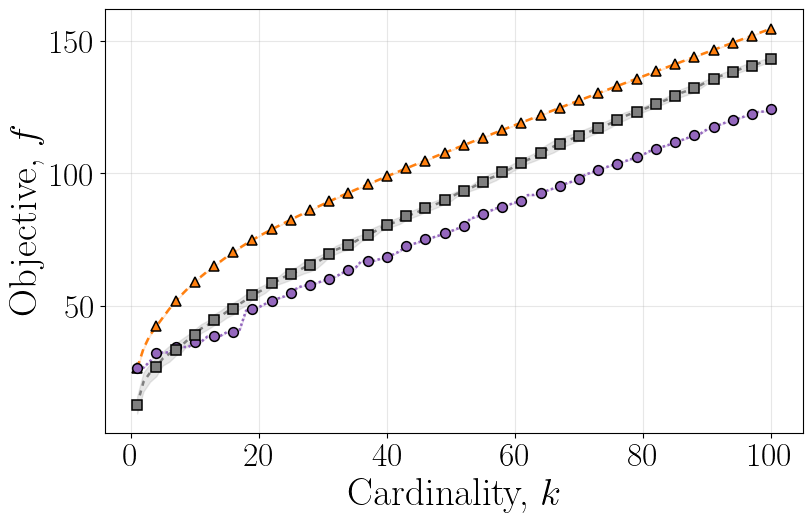

2026-02-06 18:50:04,966 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 2.740 ± 0.044
  - TopK: 1.080 ± 0.023
  - Random: 0.590 ± 0.044


In [6]:
# Adjust parameters as needed
sample_size = 300
num_runs = 5  # number of random runs
k_max = 100
findApproximateParetoSolutionsRestaurants(vegas_simMatrix, vegas_ids, sample_size, num_runs, k_max, "Yelp_Vegas")